<h2>Notes -- Image Processing with Python: Basic Transformations</h2>

<h3><a class="anchor" id="toc">Table of Contents</a></h3>

1. [Preface - Initial Setup](#Preface)<br>
   [1.1 Python Libraries and Imports](#Img_Libs)<br>
2. [Image Transformations - Overview](#Img_Transforms)<br>
   [2.1 Structure of Affine Transformations](#Img_Affine)<br>
   [2.2 Structure of Perspective Transformations](#Img_Perspective)<br>
3. [Performing Affine Transformations with cv2, PIL and skimage Libraries](#Img_Affine_Trans__Libs)<br>
   [3.1 Working with cv2 Affine Transformations](#cv2_Trans)<br>
   [3.1.1 Using cv2 for standalone translation, rotation, and scaling](#TRS_Trans_cv2)<br>
   [3.1.2 Filling in the Gaps created by cv2 Affine Transformations](#TRS_Trans_Gaps_cv2)<br>
   [3.1.3 Handling Shearing Transformations with cv2](#Shearing_Trans_cv2)<br>
   [3.1.4 Reflection Transformation with cv2](#Reflection_Trans_cv2)<br>
   [3.1.5 Flip Transformation with cv2](#Flip_Trans_cv2)<br>
   [3.1.6 Combining Affine Transformations using cv2](#Combined_Trans_cv2)<br>
   [3.1.7 Multiplying Augmented Transformation Matrices](#Multiply_matrices_cv2)<br>
   [3.2 Affine Transformations using PIL](#Affine_Trans_PIL)<br>
   [3.2.1 Using PIL for standalone and combined translation, rotation, and scaling](#TRS_Trans_PIL)<br>
   [3.3 Working with skimage Affine Transformations](#Affine_Trans_sk)<br>
   [3.3.1 Using skimage for standalone and combined translation, rotation, and scaling](#TRS_Trans_sk)   
4. [Performing Perspective Transformations with cv2, PIL and skimage Libraries](#Perspective_Trans)<br>
   [4.1 Working with cv2 Perspective Transformations](#Perspective_Trans_cv2)<br>
   [4.2 Working with PIL Perspective Transformations](#Perspective_Trans_PIL)<br>
   [4.3 Working with skimage Perspective/Projection Transformations](#Perspective_Trans_sk)<br>
5. [Closing Comment](#Closing_Comment)<br>

<a class="anchor" id="Preface"></a>
<h3>1. Preface -- Initial Setup</h3>
<a href='#toc'>Return to TOC</a>

Routines that control the screen scrolling, fronted display, and definition of all libraries used throughout the notebook.

In [1]:
# enable all interactive output to be 'printed'
# and disable scrolling so long output can be displayed w/o scroll bars

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# methods for displaying and maintaining an image in jupyter frontend
from IPython.display import Image, display

<a class="anchor" id="Img_Libs"></a>
<h4>1.1 Python Libraries and Imports</h4>
<a href='#toc'>Return to TOC</a>

The declarations shown below are used throughout the notebook. They've been posted in one place to ensure that they are not duplicated or overlooked 

In [4]:

# common libraries and functions used with image libraries

# The Python 'os' module 'provides functions for interacting with the operating system'

import os
import numpy as np
import math

# The sckit-image library (or package)
# 'io' is subpackage used for 'reading, saving, and displaying images and video'
import skimage
import skimage.io as skio
from skimage import transform as tf

# The opencv library
import cv2

# the PIL image library
import PIL

# PyLab is a procedural interface to the Matplotlib object-oriented plotting library. 

import pylab as pl

# Matplotlib is image and data visualization library
# matplotlib.pyplot is a module in Matplotlib
# and PyLab is a module that gets installed alongside Matplotlib.

from matplotlib import pyplot as plt
import matplotlib.path as mpltPath
%matplotlib inline

# The name and path of the current working directory

img_path = os.getcwd()

# Affine Transformations - translation, rotation and scaling

def get_translation(tx, ty):
    return np.float32([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

def get_rotation(angle):
    angle = np.radians(angle)
    return np.float32([
        [np.cos(angle), np.sin(angle), 0],
        [-np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])

def get_scale(s):
    return np.float32([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])

# simple print function for transformation matrix M -- saves typing

def print_M (M, title, center, angle, scale):
    print(f'Transformation matrix - {title}')
    print(f'centered at {center}, rotated {angle} and scaled {scale}.\n')
    print(M,'\n')

<a class="anchor" id="Img_Transforms"></a>
<h3>2. Image Transformations - Overview</h3>
<a href='#toc'>Return to TOC</a>

This notebook is focused on basic spatial transformations of images. A 'spatial transformation' of an image is a geometric transformation of the image coordinate system such that each pixel in an image is mapped to a pixel in a new coordinate system. The are a variety of reasons for performing spatial transformations on images. Some examples include:

<ul>
    <li>Resizing images either to create thumbnails or to create different sizes for different displays (laptops vs. tablets vs. mobile)</li>
    <li>Aligning images with a baseline image taken at a different time, from a different orientation, or with a different sensor (e.g. digital camera or imaging system)</li>
    <li>Correcting distortions that appear in an image</li>
    <li>Changing perspectives or other special effects such as morphing</li>
    <li>Generating different versions of an image to augment a machine learning dataset</li>
</ul>

<a class="anchor" id="Img_Affine"></a>
<h4>2.1 Structure of Affine Transformations</h4>
<a href='#toc'>Return to TOC</a>

Most of the transformations discussed in this notebook are 'affine transformations', which in Euclidean geometry are 'linear' transformations that preserve lines and parallelism but not necessarily distances and angles. Examples of affine transformations include translation, scaling, rotation, shear mapping, reflection, cropping and combinations of these in any sequence.

"In general, a 2D 'affine transformation' can be expressed in the form of a linear transformation followed by a vector addition" which is shown as:

$
T(x) = Ax + b
$
    
where

<ul>
    <li>x is a column vector representing the x,y coordinates of a point or pixel in the image being transformed:
$
\begin{align}
\begin{bmatrix} x \\ y  \end{bmatrix}
\end{align}
$
    </li>
    <li>A is a '2x2' matrix of coefficients controlling key aspects of the transformation
$
\begin{align}
\begin{bmatrix} a_{00} & a_{01}\\ a_{10} & a_{11}  \end{bmatrix}
\end{align}
$
    </li>
    <li>b is a column vector with two entries specifying the translation of a point in the x and y coordinates:
$
\begin{align}
\begin{bmatrix} b_{00} \\ b_{10}  \end{bmatrix}
\end{align}
$
    </li>
    <li>and T is a column vector with two entries specifying the x and y coordinates of the original point orpixel in the new transformed image:
$
\begin{align}
\begin{bmatrix} x' \\ y'  \end{bmatrix}
\end{align}
$
    </li>
</ul>

A and B can be combined into a single matrix by adding a 1 at the end of the 'x':

$
\begin{equation}
\begin{bmatrix}
x' \\ y'
\end{bmatrix}
=
\begin{bmatrix}
a_{00} & a_{01} & b_{00}\\ a_{10} & a_{11} & b_{10}
\end{bmatrix} 
\begin{bmatrix}
x \\ y \\ 1 \\
\end{bmatrix}
\end{equation}
$

When the 'A | b' matrix is multiplied with the x vector, it results in: 

$
\begin{equation}
\begin{bmatrix}
x' \\ y'
\end{bmatrix}
=
\begin{bmatrix} 
a_{00}x + a_y + b_{00}\\ a_{10}x + a_{11}y + b_{10}
\end{bmatrix}
\end{equation}
$

Linear transformations matrices (like 'A') that are augmented in this fashion by adding 'b' are called 'affine transformation matrices'. As well see, this combination is often labeled 'M'.  Without going into details, the combination 'M' enables us to use a single matrix and single matrix multiplication to represent both a linear transformation of interest (scaling, rotating, and shearing) along with translation. It also enables us to combine various transformations by multiplying their respective affine matrices (e.g. $ T_{s} @ T_{r} @ T_{tr}$ ).

Figure 1 below shows the general structure of the affine matrices for six key transformations including the 'identity' transformation. It's relatively easy to see how the augmentation works. With the exception of 'translation', all the transformation are controlled by modifying one or more of the four values in the first two columns of the matrix, i.e. the $a_{ij}$ coefficients. Similarly, translation is specified by modifying the values in third column, i.e. the $b_{ij}$ coefficients. Because there is no overlap between these two groups of cells, translation can be combined with any of the other transformations. However, to combine the other transformations, say 'scaling' followed by 'rotation', you have to multiple the two matrices. Additionally, care must be taken about the order in which the transformations are combined because the multiplication is this instance is not always 'commutative', meaning that $M_{1} @ M_{2}$ does not always yield the same results as $M_{2} @ M_{1}$. 

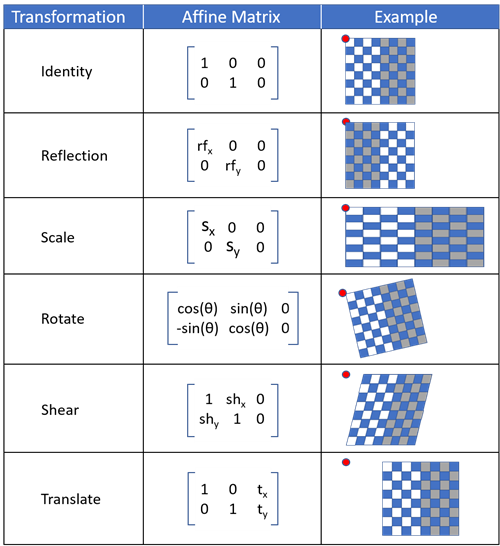

In [5]:
display(Image(filename='images/affine_transformations_small.png', embed=True))

Figure 1. Affine Transformations - Matrices and Examples
(Adapted from: Wikipedia)

First, a caveat. While these examples illustrate what transpires after a shape is transformed, we need to remember that this isn't exactly what happens with a digital image. A digital image is constrained by it's height and width, which isn't the case with these examples. So for instance, in the 'scaling' example above, without adjustments, only the left-half of the resulting image will appear unless the width of the resulting image is adjusted. Even if the width of the resulting image is adjusted to accomodate the increased length, there will still be gaps between the resulting pixels because pixels don't stretch.  Instead, gaps will appear between the pixels. The question is, how do you fill these gaps? Fortunately, ways have been developed to handle situations of this sort.

<a class="anchor" id="Img_Perspective"></a>
<h4>2.2 Structure of Perspective Transformations</h4>
<a href='#toc'>Return to TOC</a>

Affine transformations are a subset of a larger class of transformations called 'perspective transformations'. "Perspective transformations are associated with a change in the viewpoint. As the Figure 2 below indicates, the viewpoint gives the appearance of moving from a 2D world to a 3D world or vice-versa.

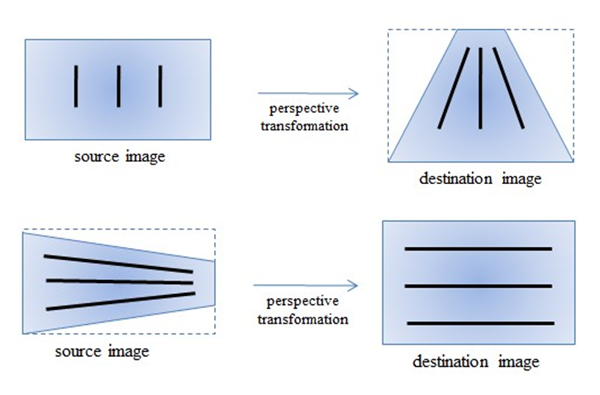

In [6]:
display(Image(filename='images/perspective_transformation_small.png', embed=True))

Figure 2: Examples of Perspective Transformations<br>
source: https://fivedots.coe.psu.ac.th/~ad/jg/ch139/index.html

As illustrated in Figure 2, this type of transformation does not preserve parallelism, length, and angle. But they do preserve collinearity and incidence. This means that the straight lines will remain straight even after the transformation."

Because affine transformations are a subset of perspective transformations, it shouldn't surprise us that both of them have the same general structure which can be represented with the augmented matrices discussed in the previous section. That is,

$
T(x) = Ax
$

where T and x are augmented (3x1) vectors and A is a (3x3) augmented matrix. More specifically,

$
\begin{equation}
\begin{bmatrix}
t_{i}x' \\ t_{i}y' \\ t_{i}
\end{bmatrix}
=
\begin{bmatrix}
a_{00} & a_{01} & b_{00}\\ a_{10} & a_{11} & b_{10}\\ c_{00} & c_{01} & 1
\end{bmatrix} 
\begin{bmatrix}
x \\ y \\ 1 \\
\end{bmatrix}
\end{equation}
$
<p>
where:
    <ul>
        <li> (x',y') refer to transformation points/pixels</li>
        <li> (x,y) are input points or pixels</li>
        <li> $t_{i}$ is a scaling factor</li>
        <li> $a_{ij}$ define transformations such as scaling and rotation</li>
        <li> $b_{ij}$ define the translation vector</li>
        <li> $c_{ij}$ define the projection vector</li>


<a class="anchor" id="Img_Affine_Trans__Libs"></a>
<h3>3. Performing Affine Transformations with cv2, PIL and skimage Libraries</h3>
<a href='#toc'>Return to TOC</a>
    
All three of the major image processing libraries -- cv2, PIL and skimages -- provide support for variety of image transformations.  In the case of affine transformations, all three have a general method, as well as specific methods, designed to handle a variety of these transformations. The following provides an overview of the general methods for each:

<ul>
    <li><b>cv2</b> -- dst_img = <em>cv2.warpAffine</em>(src_img,M,(cols,rows)) where </li><br>
        <ul>
            <li>src_img is the source image</li>
            <li>M is a 2x3 array(matrix) of float32 entries equal to the top 2 rows of transformation matrix A discussed above.</li>
            <li>(cols,rows) is a tuple equal to (img.shape[1], img.shape[0])</li>
            <li>dst_img is the destination image</li><br>
        </ul>
    <li><b>PIL</b> -- dst_img = src_img.<em>transform</em>(size, method, data=None, resample=0, fill=1, fillcolor=None) where</li><br>
        <ul>
            <li>dst_img is the destination image</li>
            <li>src_img is the source image</li>
            <li>method is 'Image.AFFINE'</li>
            <li>data is a tuple '(a, b, c, d, e, f)' which in this case is equivalent to $\begin{bmatrix} a_{00} & a_{01} & b_{00} & a_{10} & a_{11} & b_{01} \end{bmatrix} $ which are the 2 rows of the augmented transformation matrix M discussed above.</li><br>
        </ul>
    <li><b>skimage</b> -- <em>skimage.transform.AffineTransform</em>(matrix=None, scale=None, rotation=None, shear=None, translation=None, *, dimensionality=2) where</li><br>
        <ul>
            <li>matrix -- refers to an affine transformation matrix/array (2x3) of floats</li>
            <li>scale -- array, list or tuple of (sx,sy) scale factors (floats)</li>
            <li>rotation -- counter-clockwise rotation angle in radians (e.g. k*math.pi, math.pi/k, k*numpy.pi, numpy.pi/k) </li>
            <li>shear -- counter-clockwise shear angle in radians</li>
            <li>translation -- array, list or tuple of (tx,ty) translation factors (floats) </li><br>
        </ul>
If a matrix is provided, then the individual transformations are not included. Likewise, if a matrix is not provided, then at least one of the individual transformations is required.
    
Once the transformation is defined, it is actually performed by 'warp'ing it with a source image against which the tranformations are applied. The code appears something like this:
 
        M = np.array([[a00,a01,b01],[a10,a11,b10]])
        tform = transform.AffineTransform(M)
        img_dst = transform.warp(img_src, tform [,opt_params...])
    
where the key 'opt_params' include: order (order of interpolation which defaults to 'Bi-linear'); mode (determines how the points outside the boundaries of the input are filled which defaults to 'constant'; cval (specifies the RGB value used by mode to fill outside the boundaries which defaults to black (either 0.0 or (0.0,0.0,0.0)); clip (indictes whether to clip the output to the range of values outside the boundary). Again, details can be found in the 'skimage tranformation' documentation cited above.        

</ul>

To better understand the way that the general matrix 'M' is used to perform individual transformations, as well as combinations of these transformations, we'll show how each of these libraries can be used to 'geometrically' modify a simple square or rectangular image containing a simple object (i.e., either capital letter 'G', a text 'logo', or a drone) with a solid background. The selection of the objects and backgrounds is somewhat arbitrary, although: (1) they enabling us to easily visualize what's happening to the original image as it undergoes transformation; and (2) the are all asymmetrical, so we can distinguish up from down and left from right.

<a class="anchor" id="cv2_Trans"></a>
<h4>3.1 Working with cv2 Transformations</h4>
<a href='#toc'>Return to TOC</a>

Usually, the first step in using any of the image processing libraries is to read and display the image of interest. In the case of the cv2 transformations, we'll use using a square 300x300 pixel image containing the capital letter 'G' centered against a blue background (see Figure 3).

Image Type: <class 'numpy.ndarray'>
Shape: (300, 300, 3)
Colors of the pixels at locations (50,50) and (150,155):
blue [69 116 198] and white [251 255 255]


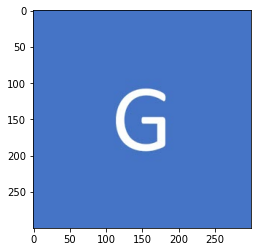

In [7]:
# First step - load the letter G

img_file = os.getcwd() + '\images\letter_G_small.jpg'
img_cv2 = cv2.imread(img_file)

# By default cv2 images employ a BGR color model. We want RGB.
# So, second step is to reverse the B and R channels

img_cv2 = img_cv2[:,:,::-1]

# The resulting image -- img_cv2 -- is displayed below
print(f'Image Type: {type(img_cv2)}')
print(f'Shape: {img_cv2.shape}')
print(f'Colors of the pixels at locations (50,50) and (150,155):')
print(f'blue [69 116 198] and white [251 255 255]')
plt.imshow(img_cv2); 


Figure 3. Capital Letter 'G' on Blue Background created with cv2

<a class="anchor" id="TRS_Trans_cv2"></a>
<h5>3.1.1 Using cv2 for standalone translation, rotation, and scaling</h5>
<a href='#toc'>Return to TOC</a>

The simplest tranformations are translation, rotation and scaling. Basically,

<ul>
    <li><b>Translation</b> -- moves the origin of an image from the upper-left corner of the screen to some other coordinate. As Figure 1 indicates there are two parameters, $t_{x}$ and $t_{y}$ - the first is the x-coordinate offset and the second is the y-coordinate offset.</li>
    <br>
    <li><b>Rotation</b> -- rotates the coordinate system so that shapes can be drawn on the screen at an angle. It has only one parameter, the angle. In this context, images or shapes are rotated relative to their origins. Positive angles denote rotations in a counter-clockwise direction and negative in a clockwise direction. While we often speak of angles in degrees, in the transformation world angles are usually specified in 'radians'. There are $2{pi}$ radians in a circle. So,  $2{pi}$ radians equals 360 degrees. Similarly, ${pi}$ radians equals 180 degrees, ${pi / 2}$ radians equals 90 degrees, ${pi / 4}$ radians equals 45 degrees, etc. Fortunately, both the numpy and math libraries have methods or functions to represent ${pi}$ and to convert from degrees to radians and vice-versa:
    <ul>
    <li>${pi}$ -- numpy.pi and math.pi</li>
    <li>degrees to radians -- numpy.radians(degrees) and math.radians(de
                grees), e.g. math.radians(45)</li>
    <li>radians to degrees -- numpy.degrees(radians) and math.degrees(radians), e.g. numpy.degrees(numpy.pi / 4)</li>
    <br>
    </ul></li>    
    <li><b>Scaling</b> -- modifies the coordinate system so that images and shapes are drawn larger or smaller. As Figure 1 shows, scale can be set for both the x and y dimensions  ($s_{x},s_{y}$), although if only one value is stated it means that the scale is applied to both dimensions equally. Scale is usually specified in terms of percentages expressed as decimals, e.g. 2 is 200% increase and .5 is a 50% increase.</li>
</ul>

To perform any of these transformations with cv2, you need to fill in the parameters for the 'warpAffine' method including the name of the source image, the desired size of the destination or output image, and most importantly, the transformation matrix M (a float32 numpy array). The process is shown below for each of these simple transformations. The end results are displayed in Figure 4. 

Transformation matrix - M_T Translation to center
centered at (150.0, 150.0), rotated 0 and scaled 1.

[[  1.   0. 150.]
 [  0.   1. 150.]] 

Transformation matrix - M_R Rotation of 30 degrees counter-clockwise
centered at (150.0, 150.0), rotated 30 and scaled 1.

[[ 0.8660254  0.5        0.       ]
 [-0.5        0.8660254  0.       ]] 

Transformation matrix - M_S Scaling 1.5 in both directions
centered at (150.0, 150.0), rotated 30 and scaled 1.

[[1.5 0.  0. ]
 [0.  1.5 0. ]] 



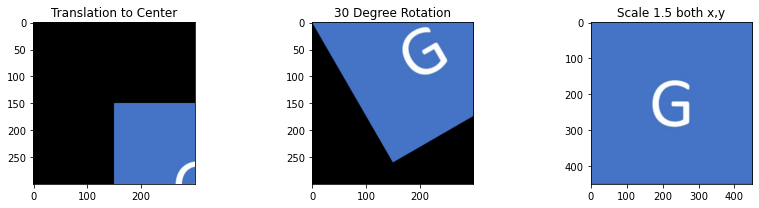

In [8]:
# copy the image so we don't accidently overwrite it

src_img = img_cv2.copy()

# 1. transition matrix M for tranlation to center of image
cols, rows = (src_img.shape[1],src_img.shape[0])
cx, cy = (cols/2, rows/2)

M_T = np.float32([[1, 0, cx],[0, 1, cy]])
dst_img_T = cv2.warpAffine(src_img,M_T,(cols,rows))

# 2. transition matrix for 30 degree rotation around (0,0)

angle = 30
theta = np.radians(angle)
csn = np.cos(theta)
sn = np.sin(theta)

M_R = np.float32([[csn, sn, 0],[-sn, csn, 0]])
dst_img_R = cv2.warpAffine(src_img,M_R,(cols,rows))

# 3. transition matrix for scalar of 1.5 with respect to both axes

sx = 1.5
sy = 1.5

s_cols = int(sx * cols)
s_rows = int(sx * rows)

M_S = np.float32([[sx, 0, 0],[0, sy, 0]])
dst_img_S = cv2.warpAffine(src_img,M_S,(s_cols,s_rows))

# print values of M_T and M_R

print_M(M_T,'M_T Translation to center',(cx,cy),0,1)
print_M(M_R,'M_R Rotation of 30 degrees counter-clockwise',(cx,cy),30,1)
print_M(M_S,'M_S Scaling 1.5 in both directions',(cx,cy),30,1)

# Display each of the transformed images
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3))
ax0.imshow(dst_img_T)
ax0.set_title("Translation to Center")
ax1.imshow(dst_img_R)
ax1.set_title("30 Degree Rotation")
ax2.imshow(dst_img_S)
ax2.set_title("Scale 1.5 both x,y")
fig.tight_layout();

Figure 4. Results of Translating, Rotating and Scaling 'G' with cv2

In the case of 'translation' the origin of the source image was moved from (0,0) to (150,150). Since the destination image wasn't scaled and retained the same dimensions as the source, the source image was clipped. The result was that 3/4ths of source was outside the boundaries of the destination. The remainder of the destination image was filled with black pixels. Since we didn't do this, the warpAffine method must have done so by default.

Similar results occurred with rotation. Without scaling, when the source image was rotated around the origin (0,0) by 30 degrees (or $pi/6$ radians) counter-clockwise, some unknown percentage of the original image landed above and beyond the top and right-side boundaries of the destination image. Again, the remainder of the destination image was filled with black pixels (by default).

In the third instance, the original source image only had 300x300=90000 pixels. Now, with scaling the destination image suddenly has 450x450=202500 pixels. That's 22,500 more pixels? If you were to copy the source image pixel-by-pixel into the destination image, placing each of the original pixels at a new location ($1.5*row, 1.5*col)$, you'd end up with an image like the one shown below in Figure 5.  So, how did the gaps get filled by warpAffine?

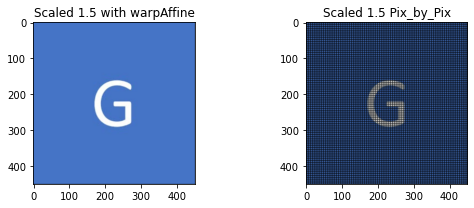

In [9]:
src_img = img_cv2.copy()
dst_pix_by_pix = np.zeros((450, 450, 3), dtype=np.uint8)

rows,cols = (src_img.shape[1],src_img.shape[0])
for i in range(cols):
    for j in range(rows):
        new_i = round(i*1.5)
        new_j = round(j*1.5)
        dst_pix_by_pix[new_i,new_j] = src_img[i,j]
        
# Display each of the transformed images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.imshow(dst_img_S)
ax0.set_title("Scaled 1.5 with warpAffine")
ax1.imshow(dst_pix_by_pix)
ax1.set_title("Scaled 1.5 Pix_by_Pix")
fig.tight_layout();

Figure 5. Image Scaled by cv2 vs. Pixel-by-Pixel Scaling

<a class="anchor" id="TRS_Trans_Gaps_cv2"></a>
<h5>3.1.2 Filling in the Gaps created by cv2 Affine Transformations</h5>
<a href='#toc'>Return to TOC</a>

The cv2.warpaffine method handles and provides control over both the filling in of the border around the transformed source image, as well as the filling in of the gaps between pixels that may occur because of interpolation. The parameters that provide these controls include:

    cv2.warpAffine(src_image, M, (cols,rows), flags=cv2.INTER_, borderMode=cv2.BORDER_, borderValue=color)
    
where

<ul>
    <li>flags -- represents interpolation mode controlling how the gaps are filled. The default flags = cv2.INTER_LINEAR, represents a linear interpolation, in addition: cv2.INTER_NEAREST (nearest neighbor interpolation), cv2.INTER_AREA (region interpolation) cv2.INTER_CUBIC (cubic spline interpolation) cv2.INTER_LANCZOS4 (Lanczos interpolation).</li><br>
    <li>borderMode -- controls the way in which the area (BORDER) surrounding the source image is filled. By default, the mode is cv2.BORDER_CONSTANT which fills in the border with a color specified by the 'borderValue'. Some of the other modes include cv2.BORDER_REPLICATE, cv2.BORDER_TRANSPARENT, cv2.BORDER_REFLECT and <a href="https://docs.opencv.org/master/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5">others</a>. One caveat, it is hard to predict the outcome of the other modes besides BORDER_CONSTANT.</li><br>
    <li>borderValue -- specifies a RGB or grayscale color value for filling in the 'border'. By default it is black -- 0, or (0,0,0) or (0,0,0,0) depending on the number of color channels in the image.</li>
</ul>

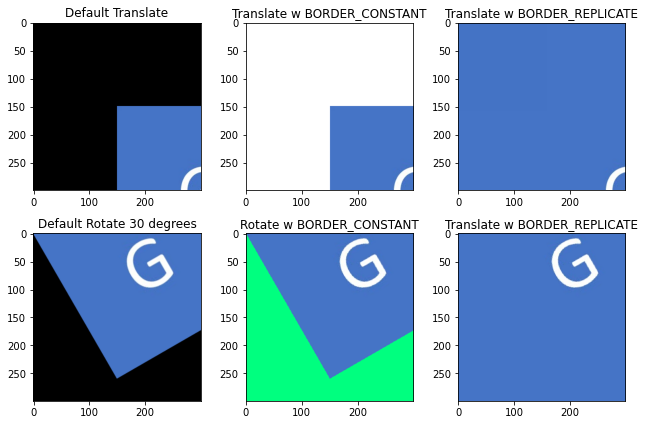

In [10]:
# Modifying the default borderValue which is black

# note: in this instance a borderValue = (68, 115, 197) 
# replicates the blue background of the original source image
# and works in the same way that BORDER_REPLICATE does.

svg_img = img_cv2.copy()
cols,rows = (svg_img.shape[1],svg_img.shape[0])

dst_img_T2 = cv2.warpAffine(src_img,M_T,(cols,rows),flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_CONSTANT,borderValue=(255, 255, 255))
dst_img_T3 = cv2.warpAffine(src_img,M_T,(cols,rows),flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_REPLICATE)

dst_img_R2 = cv2.warpAffine(src_img,M_R,(cols,rows),flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_CONSTANT,borderValue=(0, 255, 127))
dst_img_R3 = cv2.warpAffine(src_img,M_R,(cols,rows),flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_REPLICATE)


# Display each of the transformed images
plt.figure(figsize=(9,6))
plt.subplot(2,3,1)
plt.title('Default Translate')
plt.imshow(dst_img_T);
plt.subplot(2,3,2)
plt.title('Translate w BORDER_CONSTANT')
plt.imshow(dst_img_T2);
plt.subplot(2,3,3)
plt.title('Translate w BORDER_REPLICATE')
plt.imshow(dst_img_T3);

# Filling in border color for rotation
plt.subplot(2,3,4)
plt.title('Default Rotate 30 degrees')
plt.imshow(dst_img_R);
plt.subplot(2,3,5)
plt.title('Rotate w BORDER_CONSTANT')
plt.imshow(dst_img_R2);
plt.subplot(2,3,6)
plt.title('Translate w BORDER_REPLICATE')
plt.imshow(dst_img_R3);
plt.tight_layout();

Figure 6. Handling the Gaps created by cv2 Transformations

<a class="anchor" id="Shearing_Trans_cv2"></a>
<h5>3.1.3 Handling Shearing Transformations with cv2</h5>
<a href='#toc'>Return to TOC</a>

Thus far, we've only considered three of the transformations illustrated in Figure 1. Excluding 'identity', what remains are 'shearing' and 'reflection'. In this section we'll examine 'Shearing'.

In a 2D plane, an image can be sheared either horizontally or vertically. A horizontal shear displaces points by a specified amount ($sh_{x}$ parallel to the x-axis, while a vertical shear displace points by a specified amount ($sh_{y}$) parallel to the y-axis.

Shearing is accomplished by setting the transformation matrix M and the associated warpAffine method to:

    M_Sh = np.float32([[1, shx, 0],[shy, 1, 0]])
    dst_SH = cv2.warpAffine(src_img,M_Sh,(cols,rows))
    
where either of the factors may be sh = zero (no shearing), sh > 0 (positive shearing), or sh < 0 (negative shearing).

Various combinations of these two factors are shown below.

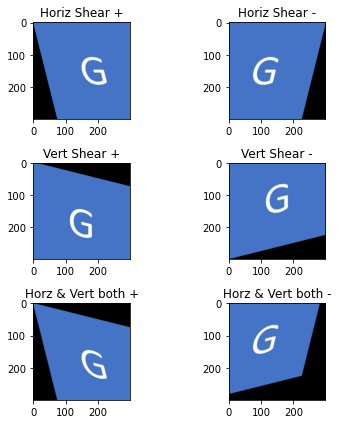

In [11]:
# Shear Transformation - Horizontal (+,-), Vertical (+,-) and Both (+,-)

src_img = img_cv2.copy()
cols, rows = (src_img.shape[1],src_img.shape[0])
#cx,cy = (cols/2,rows/2)

# Horizontal Shear + and - factors
M_ShHP = np.float32([[1,.25,0],[0,1,0]])
dst_img_ShHP = cv2.warpAffine(src_img,M_ShHP,(cols,rows))
M_ShHN = np.float32([[1,-.25,0],[0,1,0]])
dst_img_ShHN = cv2.warpAffine(src_img,M_ShHN,(cols,rows))

# Vertical Shear + and - factors
M_ShVP = np.float32([[1,0,0],[.25,1,0]])
dst_img_ShVP = cv2.warpAffine(src_img,M_ShVP,(cols,rows))
M_ShVN = np.float32([[1,0,0],[-.25,1,0]])
dst_img_ShVN = cv2.warpAffine(src_img,M_ShVN,(cols,rows))

# Horizontal and Vertical Shear both + and both -
M_ShHVP = np.float32([[1,.25,0],[.25,1,0]])
dst_img_ShHVP = cv2.warpAffine(src_img,M_ShHVP,(cols,rows))
M_ShHVN = np.float32([[1,-.25,0],[-.25,1,0]])
dst_img_ShHVN = cv2.warpAffine(src_img,M_ShHVN,(cols,rows))

# Display Shears
plt.figure(figsize=(6,6))

# Display + and - Horizontal Shear
plt.subplot(3,2,1)
plt.title('Horiz Shear +')
plt.imshow(dst_img_ShHP);
plt.subplot(3,2,2)
plt.title('Horiz Shear -')
plt.imshow(dst_img_ShHN);

# Display + and - Vertical Shear
plt.subplot(3,2,3)
plt.title('Vert Shear +')
plt.imshow(dst_img_ShVP);
plt.subplot(3,2,4)
plt.title('Vert Shear -')
plt.imshow(dst_img_ShVN);

# Display Horz & Vert both + and -
plt.subplot(3,2,5)
plt.title('Horz & Vert both +')
plt.imshow(dst_img_ShHVP);
plt.subplot(3,2,6)
plt.title('Horz & Vert both -')
plt.imshow(dst_img_ShHVN);

plt.tight_layout();

Figure 7. Various configurations of Shearing Transformations with cv2

In most of these cases, the 'shear' is cutoff, indicating that some form of scaling and/or translation is required to see the entire impact. We'll consider combined transformations more generally in a moment, but let's first look at using some combination of reflection with scaling and/or translation so that the end result of performing both horizontal and vertical shearing at the same time will appear completely in the destination image. 

In considering this problem, if you look at the last of the displays of Figure 7, you can see that: (1) in the first instance where the combined reflections are both positive, we can either shrink the image to fit into the 300x300 space or we can scale the size of the destination image to 450 to encompass it; and (2) in the second instance where the combined reflections are both negative, we probably need to both scale it and translate it (in the same way we did in the first instance).  This is what's done below.

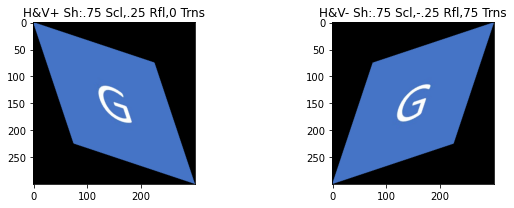

In [12]:
# combined shear, scaling and translation
src_img = img_cv2.copy()
cols, rows = (src_img.shape[1],src_img.shape[0])

scale = .75
shear = .25
translate = 0

M_ShHVP = np.float32([[scale,shear,translate],[shear,scale,translate]])
dst_img_ShHVP= cv2.warpAffine(src_img,M_ShHVP,(cols,rows))

scale = .75
shear = -.25
translate = 75

M_ShHVN = np.float32([[scale,shear,translate],[shear,scale,translate]])
dst_img_ShHVN= cv2.warpAffine(src_img,M_ShHVN,(cols,rows))

# Display each of the transformed images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9, 3))
ax0.imshow(dst_img_ShHVP)
ax0.set_title("H&V+ Sh:.75 Scl,.25 Rfl,0 Trns")
ax1.imshow(dst_img_ShHVN)
ax1.set_title("H&V- Sh:.75 Scl,-.25 Rfl,75 Trns")
fig.tight_layout();

Figure 8. Results of Combining Shearing with Translation and Scaling using cv2

It both of the above cases we scaled the source image down by 75%. However, in the second case we also translated the source by 75 pixels in both directions. The end result is that the entire image now appears in the destination image.

<a class="anchor" id="Reflection_Trans_cv2"></a>
<h5>3.1.4 Reflection Transformation with cv2</h5>
<a href='#toc'>Return to TOC</a>

Basically, reflection creates a mirror image of the source image. Reflection can occur with respect to the horizontal or x-axis, the vertical or y-axis, or both. Just like 'shear'ing, reflection is a straightforward process that is also accomplished by defining the appropriate transformation matrix M and subsequently using M in the warpAffine method: 

    M_RF = np.float32([rfx, 0, 0],[0, rfy, 0]])
    dst_img_RF = cv2.warpAffine(src_img,M_RF,(cols,rows))

where 'rfx' and 'rfy' can either be '1' for no reflection or '-1' for reflection in the specified direction.

Before we look at all of these, let's just examine horizontal reflection.

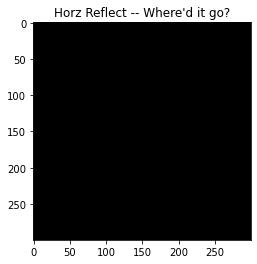

In [13]:
# Reflection Transformation - Horizontal

src_img = img_cv2.copy()
cols, rows = (src_img.shape[1],src_img.shape[0])

# Horizontal Reflection
M_RFH = np.float32([[-1,0,0],[0,1,0]])
dst_img_RFH = cv2.warpAffine(src_img,M_RFH,(cols,rows))

# Horizontal Reflection with Translatin
M_RFHT = np.float32([[-1,0,cols],[0,1,0]])
dst_img_RFHT = cv2.warpAffine(src_img,M_RFHT,(cols,rows))

# Display each of the transformed images
plt.title("Horz Reflect -- Where'd it go?")
plt.imshow(dst_img_RFH);


Figure 9. Reflection Transformation with cv2 - What's wrong?

If you think about it, without any adjustments, a horizontal reflection simply rotates the source image around the vertical axis to the left so it's no longer appears on the destination image. Same thing would happen with the vertical reflection, except it flips it up around the horizontal axis so that it also no longer appears. To get the image back on the destination image, you simply move 300 pixels to the right or 300 pixels down, or both depending on whether the reflection is horizontal, vertical or both. These cases are shown below: 

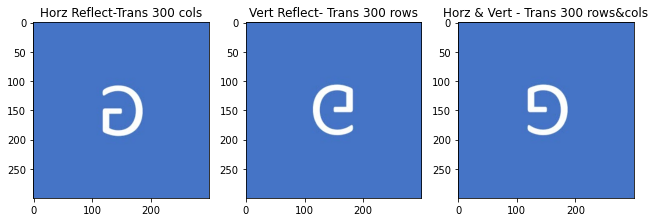

In [14]:
# Reflection Transformation - Horizontal, Vertical and Both

src_img = img_cv2.copy()
cols, rows = (src_img.shape[1],src_img.shape[0])

# Horizontal Reflection with Translation of cols = 300
M_RFH = np.float32([[-1,0,cols],[0,1,0]])
dst_img_RFH = cv2.warpAffine(src_img,M_RFH,(cols,rows))

# Vertical Reflection with Translation of rows = 300
M_RFV = np.float32([[1,0,0],[0,-1,rows]])
dst_img_RFV = cv2.warpAffine(src_img,M_RFV,(cols,rows))

# Horizontal and Vertical Reflection
M_RFHV = np.float32([[-1,0,cols],[0,-1,rows]])
dst_img_RFHV = cv2.warpAffine(src_img,M_RFHV,(cols,rows))

# Display Reflections
# Display each of the transformed images
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(9, 3))
ax0.imshow(dst_img_RFH)
ax0.set_title("Horz Reflect-Trans 300 cols")
ax1.imshow(dst_img_RFV)
ax1.set_title("Vert Reflect- Trans 300 rows")
ax2.imshow(dst_img_RFHV)
ax2.set_title("Horz & Vert - Trans 300 rows&cols")
fig.tight_layout();

Figure 10. Horizontal, Vertical, and Combined Reflecting using cv2

<a class="anchor" id="Flip_Trans_cv2"></a>
<h5>3.1.5 Flip Transformation with cv2</h5>
<a href='#toc'>Return to TOC</a>

With respect to 'reflection', cv2 provides a simpler method or function to accomplish the same task.  It's called 'Flip':
 
     dst_img = cv2.flip(src_img, flip_code)
     
where the code is '0' for flipping around the x-axis, '1' for flipping around the y-axis, and -1 for flipping around both axes. The main drawback with 'Flip' is that this method can't be easily combined with other transformations. However, as we'll see, by default it makes adjustments so the image ends up centered and scaled appropriately.

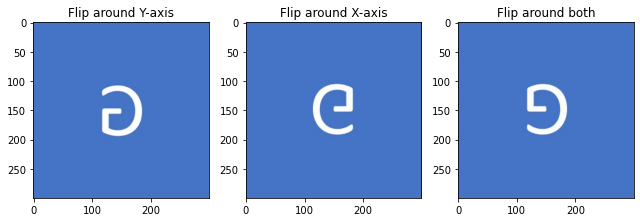

In [15]:
# Modifying the default borderValue which is black

# Note: in this instance a borderValue = (68, 115, 197) replicates the blue background of the original source image
# and works in the same way that BORDER_REPLICATE does.

src_img = img_cv2.copy()
cols, rows = (src_img.shape[1],src_img.shape[0])
cx,cy = (cols/2,rows/2)

dst_img_FY = cv2.flip(src_img,1) # This is actually a horizontal reflection
dst_img_FX = cv2.flip(src_img,0) # This is a vertical reflection
dst_img_FXY = cv2.flip(src_img,-1)

# Display Flips
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(9, 3))
ax0.imshow(dst_img_FY)
ax0.set_title("Flip around Y-axis")
ax1.imshow(dst_img_FX)
ax1.set_title("Flip around X-axis")
ax2.imshow(dst_img_FXY)
ax2.set_title("Flip around both")
fig.tight_layout();

Figure 11. Horizontal, Vertical and Combined Flip using cv2

<a class="anchor" id="Combined_Trans_cv2"></a>
<h5>3.1.6 Combining Affine Transformations using cv2</h5>
<a href='#toc'>Return to TOC</a>

For the moment let's reconsider one of the basic transformations -- rotation. As the figure below indicates, even if you start with a simple source image (like the white capital 'G' on a solid blue background shown her) and a simple transformation (like rotating counter-clockwise by a specified degrees), there are still a number of possible destinations images than can result from the transformation. The selection of a particular possibility depends in large part on the end goal of the transformation. 

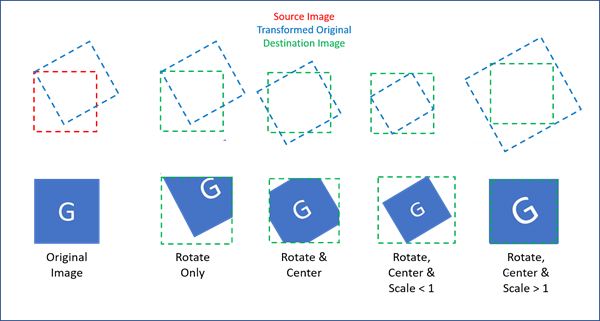

In [16]:
display(Image(filename='images/Transformation_possibilities_small.png', embed=True))

Figure 12. Potential Destination Image for a Rotated Source Image

Say, for instance, that you're a company logo designer whose been asked to produce a variety of images showing the company's name from various angles. From what we know so far and looking at Figure 12 above, it takes a combination of transformations -- rotation, translation and scaling -- to accomplish the task.

Fortunately, for this particular case there is a cv2 method (cv2.getRotationMatrix2D) that combines rotation, translation and scaling into one transformation matrix M. This matrix can then be used with cv2.warpAffine to produced the combined result. The code below shows how this works with a simple company logo containing the word 'Company' written in red on a square 300x300 muted yellow ('manilla') background.

As before, the first step is to load the logo using cv2.imread.

Image Type: <class 'numpy.ndarray'>
Shape: (300, 300, 3)
Colors of selected pixels at locations (50,50) and (100,95):
(muted yellow [255 251 240] and red [250   0   0]


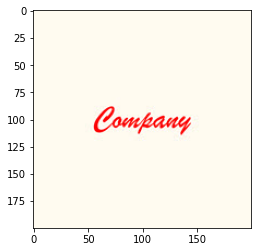

In [17]:
# First step - load the the logo

img_file = os.getcwd() + '\images\company_logo_v_small.jpg'
img_logo = cv2.imread(img_file)

# By default cv2 images employ a BGR color model. We want RGB.
# So, second step is to reverse the B and R channels

img_logo = img_logo[:,:,::-1]

# The resulting image -- img_cv2 -- is displayed below
print(f'Image Type: {type(img_cv2)}')
print(f'Shape: {img_cv2.shape}')
print(f'Colors of selected pixels at locations (50,50) and (100,95):')
print(f'(muted yellow {img_logo[50,50]} and red {img_logo[100,95]}')
plt.imshow(img_logo); 

Figure 13. Company Logo loaded with cv2.imread

The second step is to actually translate, rotate and scale the image using cv2.getRotationMatrix2D. All that required is to specify the translation point, the angle of rotations and the scale factor. This has been done below for a select set of these variables. 

Transformation matrix - M_TR Translate center,Rotate 45,Scale 1
centered at (100.0, 100.0), rotated 45 and scaled 1.0.

[[  0.70710678   0.70710678 -41.42135624]
 [ -0.70710678   0.70710678 100.        ]] 

Transformation matrix - M_TRS Translate center,Rotate 45,Scale 1.5
centered at (100.0, 100.0), rotated 45 and scaled 1.5.

[[   1.06066017    1.06066017 -112.13203436]
 [  -1.06066017    1.06066017  100.        ]] 

Transformation matrix - M_TRS Translate center,Rotate 75,Scale 1.5
centered at (100.0, 100.0), rotated 75 and scaled 1.5.

[[  0.38822857   1.44888874 -83.71173071]
 [ -1.44888874   0.38822857 206.06601718]] 



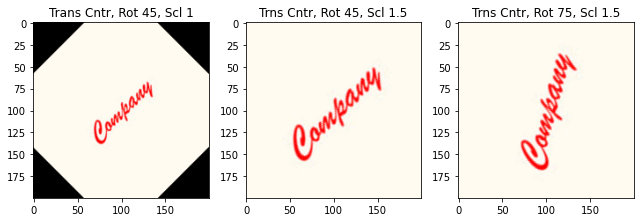

In [18]:
# company logo at an angle

src_logo_img = img_logo.copy()


cols, rows = (src_logo_img.shape[1],src_logo_img.shape[0])
center = (cols/2,rows/2)
angle = 45
scale = 1.0

M_RT = cv2.getRotationMatrix2D(center, angle, scale)
print_M(M_RT,'M_TR Translate center,Rotate 45,Scale 1',center,angle,scale)
dst_logo_img_RT = cv2.warpAffine(src_logo_img,M_RT,(cols,rows))

scale = 1.5
M_RTS = cv2.getRotationMatrix2D(center, angle, scale)
print_M(M_RTS,'M_TRS Translate center,Rotate 45,Scale 1.5',center,angle,scale)
dst_logo_img_RTS = cv2.warpAffine(src_logo_img,M_RTS,(cols,rows))

angle = 75
M_R75TS = cv2.getRotationMatrix2D(center, angle, scale)
print_M(M_R75TS,'M_TRS Translate center,Rotate 75,Scale 1.5',center,angle,scale)
dst_logo_img_R75TS = cv2.warpAffine(src_logo_img,M_R75TS,(cols,rows))

# Display
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(9, 3))
ax0.imshow(dst_logo_img_RT)
ax0.set_title("Trans Cntr, Rot 45, Scl 1")
ax1.imshow(dst_logo_img_RTS)
ax1.set_title(("Trns Cntr, Rot 45, Scl 1.5"))
ax2.imshow(dst_logo_img_R75TS)
ax2.set_title(("Trns Cntr, Rot 75, Scl 1.5"))
fig.tight_layout();

Figure 14: Translating, Rotating and Scaling an image using cv2.getRotationMatrix2D

<a class="anchor" id="Multiply_matrices_cv2"></a>
<h5>3.1.7 Multiplying Augmented Transformation Matrices</h5>
<a href='#toc'>Return to TOC</a>

Obviously, cv2.getRotationMatrix2D is consolidating the three transformations - rotation, translation and scaling - to produce a single matrix that generates the overall result. Complex affine transformations are usually constructed from a ordered combination of matrix operations. The primary operation is matrix multiplication. For example, to carry out a translation followed by a rotation, we multiply the matrix for rotation (say M_R) times the matrix for translation (say M_T) in that order, i.e., M_RT = M_R @ M_T. Matrix multiplication, unlike scalar multiplication, is not 'commutative'. So, M_R @ M_T usually doesn't equal M_T @ M_R. Thus, there's obviously a set order in the way cv2.getRotationMatrix2D operates, although it's not immediately apparent what it is. In a moment we'll demonstrate what the sequence is.

There's another important issue that isn't obvious about the way cv2.getRotationMatrix2D operates. The 2x3 transformation matrices we've been using, cannot be multiplied with one another in their current state. In order to multiply two matrices with each other, the number of columns in the first matrix must equal the number rows in the second matrix. For example, to multiple M_R and M_T the number of columns in M_R must equal the number of rows in M_T. As noted, M_R is 2 x 3 and so is M_T. The 3 columns of M_R don't equal the 2 rows of M_T. So, no multiplication. 
 
How do we get around this? The answer is that we 'augment' the matrices by incorporating the row '\[0, 0, 1\]' at the end of each of the matrices. Thus, any of the transformation matrices becomes:

    M = np.float32([[a00, a01, b01],[a10, a11, b11],[0, 0, 1]])
    
Essentially, for any affine transformation, the addition of this row is benign except that it makes all the matrices 3x3. This enables multiplication. However, even though they can be multiplied, it doesn't help us understand what the sequence of multiplications should be for any given goal.

To be understand this, let's try to determine what sequence is being used by cv2.getRotationMatrix2D. This is done below in steps. As a first step, we'll create a set of functions to produce augmented matrices for each of the primary transformations. Next, we'll multiple various sequences of these augmented matrices to demonstrate that order matters. Finally, we'll compare a couple of matrices produced by getRotationMatrix2D with a few of the sequences.

In [19]:
# Multiplying Affine Transformation Matrices

src_img = img_logo.copy()

cols,rows = (src_img.shape[1],src_img.shape[0])
center = (cols/2,rows/2)
cx,cy = center
angle = 30
scale = 1.5

# set up augmented matrices
R = get_rotation(30)
T = get_translation(cx,cy)
NT = get_translation(-cx,-cy) # negative translations move the image back to position before rotation
S = get_scale(scale)

# single operations
print('1. R\n', R, '\n')
print('2. T\n', T, '\n')
print('3. NT\n', NT, '\n')
print('4. S\n', S, '\n')

# multiplying 2 matrices
R_T = R @ T
T_R = T @ R
R_S = R @ S
S_R = S @ R

print('Multiplying 2 Matrices:')
print_M(R_T,'5. R_T = R @ T',(cx,cy),angle,1)
print_M(T_R,'6. T_R = T @ R',(cx,cy),angle,1)
print_M(R_S,'7. R_S = R @ S',(cx,cy),angle,scale)
print_M(S_R,'8. S_R = S @ R',(cx,cy),angle,scale)

# multiplying 3 matrices - makes no sense to multiply T @ NT
T_R_NT = T @ R @ NT
T_S_NT = T @ S @ NT

print('Multiplying 3 Matrices:')
print_M(T_R_NT,'9. T_R_NT = T @ R @ NT',(cx,cy),angle,1)
print_M(T_S_NT,'10. T_S_NT = T @ S @ NT',(cx,cy),angle,scale)

# multiplying 4 matrices
T_S_R_NT = T @ S @ R @ NT
T_R_S_NT = T @ R @ S @ NT
print('Multiplying 4 Matices')
print_M(T_S_R_NT,'11. T_S_R_NT = T @ S @ R @ NT',(cx,cy),angle,scale)
print_M(T_R_S_NT,'12. T_R_S_NT = T @ R @ S @ NT',(cx,cy),angle,scale)

# compare to getRotationMatrix2d
M = cv2.getRotationMatrix2D(center, angle, scale)
print_M(M, '13. getRotationMatrix2d',(cx,cy),angle,scale)

1. R
 [[ 0.8660254  0.5        0.       ]
 [-0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]] 

2. T
 [[  1.   0. 100.]
 [  0.   1. 100.]
 [  0.   0.   1.]] 

3. NT
 [[   1.    0. -100.]
 [   0.    1. -100.]
 [   0.    0.    1.]] 

4. S
 [[1.5 0.  0. ]
 [0.  1.5 0. ]
 [0.  0.  1. ]] 

Multiplying 2 Matrices:
Transformation matrix - 5. R_T = R @ T
centered at (100.0, 100.0), rotated 30 and scaled 1.

[[  0.8660254   0.5       136.60254  ]
 [ -0.5         0.8660254  36.60254  ]
 [  0.          0.          1.       ]] 

Transformation matrix - 6. T_R = T @ R
centered at (100.0, 100.0), rotated 30 and scaled 1.

[[  0.8660254   0.5       100.       ]
 [ -0.5         0.8660254 100.       ]
 [  0.          0.          1.       ]] 

Transformation matrix - 7. R_S = R @ S
centered at (100.0, 100.0), rotated 30 and scaled 1.5.

[[ 1.299038  0.75      0.      ]
 [-0.75      1.299038  0.      ]
 [ 0.        0.        1.      ]] 

Transformation matrix - 8. S_R = S @ R
centere

The contents of the various matrices produced by the above steps is summarized below:
<ul>
    <li>Matrices 1-4 provide the augmented matrices for the basic transformations - translation, rotation and scaling.</li><br>
    <li>Matrices 5-8 display the results from multiplying 2 matrices. Turns out that R@T and T@R are not equivalent while R@S and S@R are the same. This is because in these examples, sx=sy so it like multiplying by a scalar. In these examples the two are equal because this is the assumption that getRotationMatrix2D makes.</li><br>
    <li>Matrices 9-10 display the results from multiplying 3 matrices. In this case, we don't consider the instances where T and NT are multiplied together because this produces an identity matrix which when multiplied by any other matrix simply yields that matrix.</li><br>
    <li>Matrices 11-12 provide the results from multiplying (T @ S @ R @ NT) versus multiplying (T @ R @ S @ NT). These turn out to be the same because S @ R is the same as R @ S.</li><br>
    <li>Finally, looking at M from 'getRotationMatrix2D' we find that this is the same matrix as the product of (T @ S @ R @ NT). One could suggest that it's simpler to use 'getRotationMatrix2D' than creating the product by multiplying the 4 matrices. However, as suggested 'getRotationMatrix2D' only handles the case where scaling in the x and y directions are the same. When they are different you need to adjust the 'getScale' function to use 'sx,sy' as parameters rather than a single 'scale' value and check which order (R @ S) or (S @ R) produces the results you're looking for.</li>
</ul>

The images that follow indicate the type of results the are produced by multiplying the 4 matrices together first with the a scale value of .73 and then with a scale value of 1.5. Notice that cv2.warpAffine is still expecting a 2x3 matrix (top 2 rows of the augmented transformation matrix). 

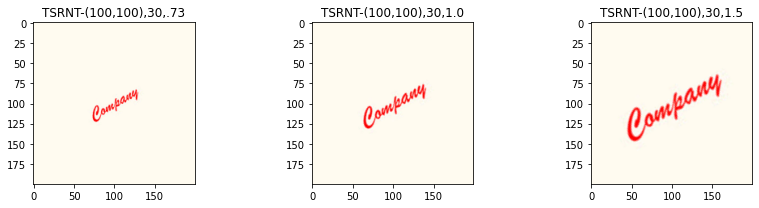

In [20]:
img_src = img_logo.copy()

S1 = get_scale(.73)
T_S1_R_NT = T @ S1 @ R @ NT

S2 = get_scale(1.0)
T_S2_R_NT = T @ S2 @ R @ NT

S3 = get_scale(1.5)
T_S3_R_NT = T @ S3 @ R @ NT

dst_img_TS1RNT = cv2.warpAffine(img_src,T_S1_R_NT[:2,:],(cols,rows),borderMode=cv2.BORDER_REPLICATE)
dst_img_TS2RNT = cv2.warpAffine(img_src,T_S2_R_NT[:2,:],(cols,rows),borderMode=cv2.BORDER_REPLICATE)
dst_img_TS3RNT = cv2.warpAffine(img_src,T_S3_R_NT[:2,:],(cols,rows),borderMode=cv2.BORDER_CONSTANT,borderValue=(255, 250, 240))

# Display each of the channel images with matplotlib
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3))
ax0.imshow(dst_img_TS1RNT)
ax0.set_title("TSRNT-(100,100),30,.73")
ax1.imshow(dst_img_TS2RNT)
ax1.set_title("TSRNT-(100,100),30,1.0")
ax2.imshow(dst_img_TS3RNT)
ax2.set_title("TSRNT-(100,100),30,1.5")
fig.tight_layout();

Figure 15. Variations in Company Logos produced by Multiplying Tranformation Matrices using cv2

Taken together these images begin to give you a sense of how the logo will look at this particular angle at varying sizes. The actual production of these images could easily be automated to run through various angles, positions, scales and color schemes, simply by adding some nested 'for loops'.

<a class="anchor" id="Affine_Trans_PIL"></a>
<h4>3.2 Affine Transformations using PIL</h4>
<a href='#toc'>Return to TOC</a>

As noted earlier, like cv2, both PIL/pillow and skimage provide general modules for performing affine and perspective transformations. Because there is substantial overlap in the way transformations work, we're only going to cover a few of the basic transformations for each library without providing detailed commentary like we did with cv2.

For a bit of variety, we're going to illustrate the PIL (and skimage) transformations using an image of a drone photographed against a blue sky and stored as a jpeg file.  When this file is read with PIL.Image.open, the resulting image is of type 'JpegImageFile'. This structure is 'proprietary' to PIL/pillow and differs in key ways from the numpy array structure employed by both cv2 and skimage. 

First, there are significant differences in the coordinate system used by PIL images. While all of the images from the three libraries have their origin in the upper-left corner, each pixel in a PIL image is designated by (row,col) or (y,x) which is the opposite from cv2 and skimage images. Consequently, when we scale, translate, or rotate we have to adjust the elements of the various transformation matrices to account for this difference. For instance, when we create the matrix for translating an image, instead of \[\[0, 0, tx\],\[0, 0, ty\]\] it's \[\[0, 0, -tx\],\[0, 0, -ty\]\] and vice-versa. Similarly, when we rotate, a counter-clockwise angle is denoted by negative angle (-angle). Finally, when we set the scale factor s (or sx,sy) we use the reciprocal 1/s, so that values greater than 1.0 decrease scale while numbers less than 1.0 increase. The example below illustrates the process for a series of individual and a composite transformations that result in a 'zoomed, tilted' image of the drone. 

Second, the value of a pixel is not directly accessible in the PIL library. While there is no immediate need to read or change pixel values in affine transformations, the need does arise in handling perspective or projection transformations. With cv2 and skimage, the process of reading and/or modifying a pixel value is straightforward. You simply access the value in an array, e.g. accessing img\[i,j\] yields the current value and img\[i,j\]= (r,g,b) modifies the current value. In contrast, if you want to access and/or modify a pixel in PIL, you need to 'load' the image, then use PIL's 'getpixel' and /or 'putpixel' methods to accomplish the same tasks.

Note: A detailed discussion of the coordinate systems of all three image libraries can be found in the following Jupyter notebook: <a href="https://nbviewer.jupyter.org/github/daveking63/Notes_on_Image_Processing_and_Computer_Vision/blob/main/Image_Coordinate_Systems_and_Color_Models/notes_for_image_processing_coordinates_colors_git_version2.ipynb">Image Processing with Python: Coordinates and Colors</a>.

Characteristics of PIL drone JPG Image
Data type <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image Format JPEG
Size is width by height: (300, 300)
Width: 300
Height: 300
Number of pixels: 90000


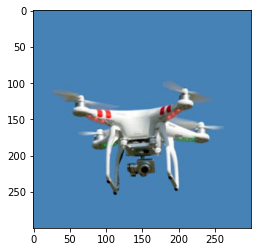

In [21]:
img_file = os.getcwd() + '\images\drone_bbg.jpg'
img_drone_PIL = PIL.Image.open(img_file)

print('Characteristics of PIL drone JPG Image')
print("Data type {}".format(type(img_drone_PIL)))
print("Image Format", img_drone_PIL.format)
print("Size is width by height: {}".format(img_drone_PIL.size))
print("Width: {}".format(img_drone_PIL.width))
print("Height: {}".format(img_drone_PIL.height))
print("Number of pixels: {}".format(img_drone_PIL.width * img_drone_PIL.height))

plt.imshow(np.asarray(img_drone_PIL));

Figure 16. Drone Image loaded using PIL's 'Image.open'

<a class="anchor" id="TRS_Trans_PIL"></a>
<h5>3.2.1 Using PIL for standalone and combined translation, rotation, and scaling</h5>
<a href='#toc'>Return to TOC</a>

To perform any of these transformations with PIL, you need to fill in the parameters for the '<dst_image>.transform' method. Here, <dst_image> indicates that the transform method applies to a destination image (e.g. in the example below 'dst_img_R' is the name of the image that will contain the rotated source image (e.g. 'src_img'). PIL's transform method has three parameters including the 'size' of the source image, the name of the transformation method which in this case is 'PIL.Image.AFFINE', and the name of the flattened transformation vector.  The process of creating a tranformed image image using PIL  is shown below for translation, rotation, and scaling along with an image generated by combining these simple tranformations. The end results are displayed in Figure 4 with the final result being a 'zoomed, tilted' image of the drone.

Example of Transition Matrix and 'Flattened' Transformation Vector 

Rotation Matrix R: 

[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]] 

Flattened Vector data_R: 

[ 0.8660254 -0.5        0.         0.5        0.8660254  0.       ] 



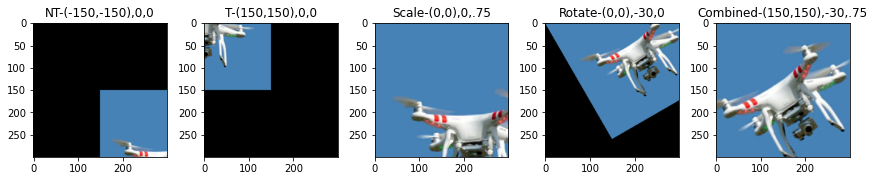

In [22]:
# translated origin from (0,0) to (cx, cy), center of img

src_img = img_drone_PIL.copy()

cx = src_img.width/2
cy = src_img.height/2

# center the image
tnx, tny = (-cx,-cy) 
tx, ty = (cx,cy)

# scale - Note in PIL as opposed to cv2 the scale is treated as 1/scale rather than scale.
s = 1.0/1.5 

# rotation 
angle = -30 # we used negative values to go counter-clockwise
theta = np.radians(angle)
csn = np.cos(theta)
sn = np.sin(theta)

# set up augmented matrices with last row [0,0,1]
# This enables multiplication. 'get' functions from earlier

NT = get_translation(-cx,-cy)
T = get_translation(cx,cy)
R = get_rotation(-30)
S = get_scale(s)

# goal is to translate, scale, and rotate, and then translate to bring image back to center
# multiply the augmented matrices to derive the combined transformation

TRSNT = T @ R @ S @ NT

# data = (a, b, c, d, e, f)
# PIL requires a vector made of the top 2 rows of the transformation matrices
data_NT = NT[:2,:].flatten()
data_T = T[:2,:].flatten()
data_S = S[:2,:].flatten()
data_R = R[:2,:].flatten()
data_TRSNT = TRSNT[:2,:].flatten()

# Sample print of transformation matrix and flattened transformation matrix
print("Example of Transition Matrix and 'Flattened' Transformation Vector","\n")
print("Rotation Matrix R:","\n")
print(R,'\n')
print("Flattened Vector data_R:",'\n')
print(data_R,'\n')

# images for each of the tranformations taken individually and
# then for the transformation generated by multiplying individual matrices 
dst_img_NT = src_img.transform(src_img.size, PIL.Image.AFFINE, data_NT)
dst_img_T = src_img.transform(src_img.size, PIL.Image.AFFINE, data_T)
dst_img_S = src_img.transform(src_img.size, PIL.Image.AFFINE, data_S)
dst_img_R = src_img.transform(src_img.size, PIL.Image.AFFINE,data_R)
dst_img_TRSNT = src_img.transform(src_img.size, PIL.Image.AFFINE, data_TRSNT) 

# display
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, figsize=(12, 3))
ax0.imshow(dst_img_NT)
ax0.set_title("NT-(-150,-150),0,0")
ax1.imshow(dst_img_T)
ax1.set_title("T-(150,150),0,0")
ax2.imshow(dst_img_S)
ax2.set_title("Scale-(0,0),0,.75")
ax3.imshow(dst_img_R)
ax3.set_title("Rotate-(0,0),-30,0")
ax4.imshow(dst_img_TRSNT)
ax4.set_title("Combined-(150,150),-30,.75")
fig.tight_layout();


Figure 17. Affine Transformations using PIL

<a class="anchor" id="Affine_Trans_sk"></a>
<h4>3.3 Affine Transformations using skimage</h4>
<a href='#toc'>Return to TOC</a>

Documentation for the skimage transformations of all sorts is found at: https://scikit-image.org/docs/dev/api/skimage.transform.html).

When it comes to affine transformations of an image, skimage operates very similar to the way cv2 works. The main difference is that the skimage 'transform' module works with 'augmented' (3x3) affine matrices rather than the 2x3 matrices used with cv2.

<a class="anchor" id="TRS_Trans_sk"></a>
<h5>3.3.1 Using skimage for standalone and combined translation, rotation, and scaling</h5>
<a href='#toc'>Return to TOC</a>

Like cv2 and PIL, producing an affine transformation with skimage is a three-step process:

<ol>
    <li>Load the image of interest (see Figure 18)</li><br>
    <li>Create the appropriate affine matrix for the transformation of interest using 'transform.AffineTransform'</li><br>
    <li>Produce the transformed image with transform.warp. Again, the process is illustrated below for a series of individual transformations, as well as a combined transformation, aimed at producing the 'zoomed, tilted' image of the drone (see Figure 19).

Characteristics of skimage drone JPG Image
data type: <class 'numpy.ndarray'>
Shape of img_sk (300, 300, 3)
Value of img_sk[0,0]: [ 70 130 182]


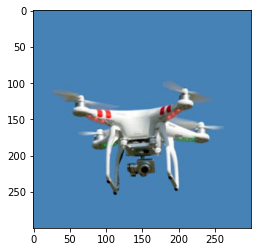

In [23]:
img_file_sk = os.getcwd() + '\images\drone_bbg.jpg'
img_sk = skio.imread(img_file_sk)

print("Characteristics of skimage drone JPG Image")
print("data type: {}".format(type(img_sk)))
print("Shape of img_sk {}".format(img_sk.shape))
print("Value of img_sk[0,0]: {}".format(img_sk[0,0]))
plt.imshow(img_sk);

Figure 18. Drone Image loaded using skimage 'skio.imread'

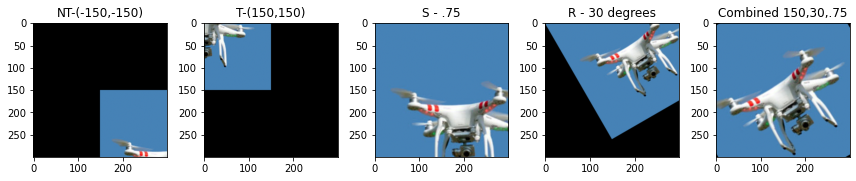

In [24]:
#general structure of transformation process
#trans_matrix = np.array([[a11,a12,b1],[a21,a22,b2],[0,0,1]])
#tform = transform.AffineTransform(A)
#dst_img = tf.warp(src_img, tform)

src_img = img_sk.copy()

# center
cx = src_img.shape[1]/2
cy = src_img.shape[0]/2

# scale
s = .75

# rotation 
angle = -30 # we used negative values to go counter-clockwise

# transformation matrices
NT = get_translation(-cx,-cy)
T = get_translation(cx,cy)
R = get_rotation(angle)
S = get_scale(s)
TRSNT = T @ R @ S @ NT

# affine transformations
tform_NT = tf.AffineTransform(matrix = NT)
tform_S = tf.AffineTransform(matrix = S)
tform_R = tf.AffineTransform(matrix = R)
tform_T = tf.AffineTransform(matrix = T)
tform_TRSNT = tf.AffineTransform(matrix = TRSNT)

# destination images
dst_img_NT = tf.warp(src_img, tform_NT)
dst_img_S = tf.warp(src_img, tform_S)
dst_img_R = tf.warp(src_img, tform_R)
dst_img_T = tf.warp(src_img, tform_T)
dst_img_TRSNT = tf.warp(src_img, tform_TRSNT)

# display
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, figsize=(12, 3))
ax0.imshow(dst_img_NT)
ax0.set_title("NT-(-150,-150)")
ax1.imshow(dst_img_T)
ax1.set_title("T-(150,150)")
ax2.imshow(dst_img_S)
ax2.set_title("S - .75")
ax3.imshow(dst_img_R)
ax3.set_title("R - 30 degrees")
ax4.imshow(dst_img_TRSNT)
ax4.set_title("Combined 150,30,.75")
fig.tight_layout();

Figure 19. Affine Transformations using skimage

<a class="anchor" id="Perspective_Trans"></a>
<h4>4. Performing Perspective Transformations with cv2, PIL and skimage Libraries</h4>
<a href='#toc'>Return to TOC</a>
                      
Affine transformations are a subset of a larger class of transformations called 'perspective transformations'. Perspective transformations are associated with a change in the viewpoint. As the Figure 20 indicates, the viewpoint gives the appearance of moving from a 2D world to a 3D world or the reverse.

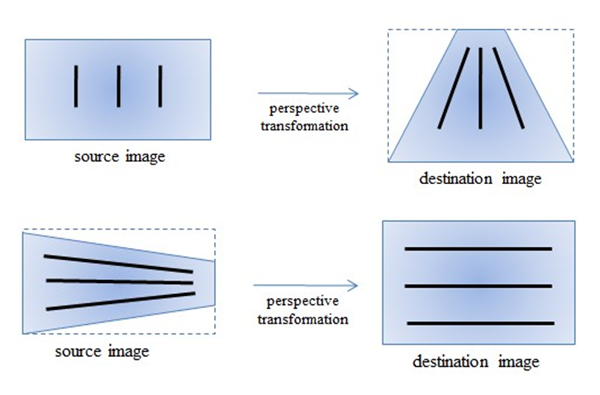

In [25]:
display(Image(filename='images/perspective_transformation_small.png', embed=True))

Figure 20. Perspective Transformations - Basic Idea<br>
source: https://fivedots.coe.psu.ac.th/~ad/jg/ch139/index.html

As illustrated in Figure 20, this type of transformation does not preserve parallelism, length, and angle, but it does preserve collinearity and incidence. This means that the straight lines will remain straight even after the transformation.

Because affine transformations are a subset of perspective transformations, it shouldn't surprise us that both of them have the same general structure which can be represented with the 'augmented' matrices discussed in the previous section. That is,

$
T(x) = Ax
$

where T and x are augmented (3x1) vectors and A is a (3x3) augmented matrix. More specifically,

$     
      \begin{bmatrix}
        t_{i}x' \\ t_{i}y' \\ t_{i}
      \end{bmatrix}
      =
      \begin{bmatrix}
      a_{00} & a_{01} & b_{00}\\ a_{10} & a_{11} & b_{10}\\ c_{00} & c_{01} & 1
      \end{bmatrix} 
      \begin{bmatrix}
        x \\ y \\ 1 \\
      \end{bmatrix}  
$
<p>
where 
    
<ul>
    <li> x',y' refers to the coordinates of a transformation point in a destination image</li>
    <li> $t_{i}$ is a scaling factors applied to the transformation point</li>
    <li> x,y are the coordinates of an input point in a source image</li>
    <li> $a_{ij}$ defines various transformations such rotation and scaling applied to the input point</li>
    <li> $b_{ij}$ defines the translation vector applied to the input point</li>
    <li> $c_{ij}$ defines a projection vector applied to the input point.</li>
</ul>

Regardless of the image processing library used to perform the perspective transformation -- cv2, PIL or skimage -- the end goal is basically the same. You're taking an area of a source image and projecting it onto a specified area of a destination image. In order to do this you need to specify a vector of points in the source image and a vector or corresponding points in the destination image. Say, for instance, that you want to project the square image of the company logo used earlier to demonstrate various cv2 transformations onto a monitor screen appearing in a rectangular image (see Figure 21 below). Since the logo is contained within a square image, we need a vector of 4 coordinates to define it. Correspondingly, we need a vector of 4 coordinates in the monitor image to define the screen area where the logo is to be projected. Of course, the number of points vary from one shape to the next.

The ordering of the coordinates within these vectors should be the same. While the order can vary from one library to the next, they either flow from the origin (here 's1' and 'd1) in a clockwise fashion or a counter-clockwise direction. Once the coordinates are determined, the next step is to compute a matrix defining the transformations required to project from the source image to the destination image. Fortunately, each of the libraries provides a method for doing this.

In the same vein, once you have the transformation matrix in hand, you can use a 'perspective transformation' method provided by the same library to compute the projected destination image. Unfortunately, this isn't the final step. The destination image generated by a perspective transformation method typically results in an image containing the projected area surrounded by a black border or background (which is a default color that can be changed). However, what you want is the projected area surrounded by the original destination image. The question is: how do you do this?

There are a couple of approaches. You could replace the black border surrounding the projected area with corresponding pixels from the original destination image, or you could put the projected area on the original destination image. In this discussion we've chosen to do the later. Basically, we do this by brute-force, testing whether each pixel in the projected image is black. If it is, we ignore it. If it isn't black, we copy the pixel from the transformed image and use it to replace the corresponding image in the original destination image. In this way the projected area is copied to the corresponding location on the original destination image. Of course, there are more elegant ways to do this, but this suffices for our purposes.

In the discussion that follows we use each of the image libraries - cv2, PIL and skimage in that order - to project either the company logo image or the drone image used earlier onto the monitor screen shown in Figure 21. The processes that are used by each are basically the same, although there are some minor differences.

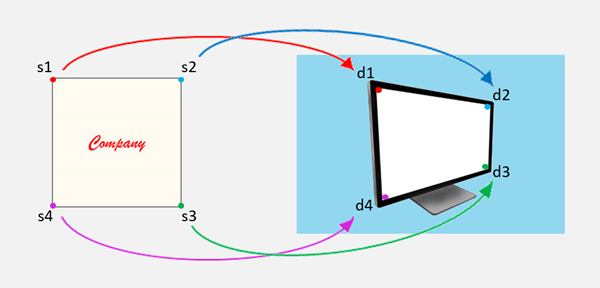

In [26]:
display(Image(filename='images/perspective_picture_small.png', embed=True))

<a class="anchor" id="Perspective_Trans_cv2"></a>
<h4>4.1 Working with cv2 Perspective Transformations</h4>
<a href='#toc'>Return to TOC</a>

Like affine transformations, cv2 provides a method --  cv2.getPerspectiveTransform() -- for defining the transformation matrix M which is then used by a second method -- cv2.warpPerspective() -- to transform a source image into a destination image (similar to cv2.warpAffine). The details are shown below:
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts) where
    src_pts: 4 points (x,y) in the source image
    dst_pts: 4 destination points (x',y') in the destination image linked to associated src_pts
    
and
    
    dst_img = cv2.warpPerspective(src, M, dsize, dst, flags, borderMode, borderValue) where
    src: source (input) image.
    dst: destination (output) image that has the size dsize and the same type as src .
    M: 3×3 transformation matrix.
    dsize: size of the output image.
    flags: INTER_LINEAR or INTER_NEAREST or WARP_INVERSE_MAP (sets M as the inverse transformation ( dst→src )).
    borderMode:	pixel extrapolation method (BORDER_CONSTANT or BORDER_REPLICATE).
    borderValue: (r, g, b) used in case of a constant border; by default, it equals 0 (black).
    
To illustrate the process of creating a perspective view of an image using 'cv2.getPerspectiveTransform' and 'cv2.warpPerspective', we going to project our 300x300 square 'company logo' onto the screen of a computer monitor displayed in a 300x450 rectangular image.

The first step is to read in the image of the computer monitor (img_monitor). The image of the 'company logo' already exists as 'img_logo'.

Type: <class 'numpy.ndarray'>
Shape: (300, 450, 3)


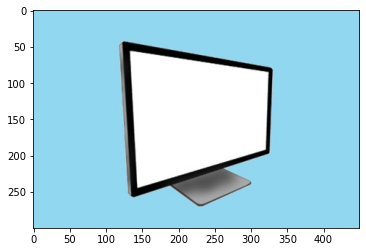

In [27]:
img_file = os.getcwd() + '\images\perspective_monitor.jpg'
img_monitor = cv2.imread(img_file)
img_monitor = img_monitor[:,:,::-1]

print(f'Type: {type(img_monitor)}')
print(f'Shape: {img_monitor.shape}')
plt.imshow(img_monitor)

Figure 22. Loading the Image of a Computer Monitor with cv2.imread

The initial key to displaying the 'company logo' on the monitor screen is derive the common touch points for the two images. In this case, the source image is the logo and the destination image is the monitor screen. The 4 points of interest in the logo are the corners of the image. These points are given by:

    src_pts = np.float32([[0,0],[h-1,0],[h-1,w-1],[0,w-1]])
  
Within the destination (monitor) image, the location of the monitor screen is given by:
 
    dst_pts = np.float32([[135,57],[323,84],[320,191],[143,242]]) 
    
These were determined manually by viewing the image in a drawing program and determine the values by pinpoint the appropriate pixels with a mouse.
 
With these points in hand, the next step is to derive the transition matrix M using cv2.getPerspectiveTransform. Once M is determined, it's fed to cv2.warpPerspective. The end result is shown in the Figure 23 below. Basically, this is the source image in perspective view surrounded by a black border (by default). However, we want this image to be on the monitor screen.

To accomplish this, we test each pixel in the dst_image to see if it's black which in RGB terms is (0,0,0). If it is, we ignore it. If it isn't, we replace the corresponding pixel in the original monitor image with the pixel in the dst_image. The end result is shown on the right-hand side of Figure 23 below.

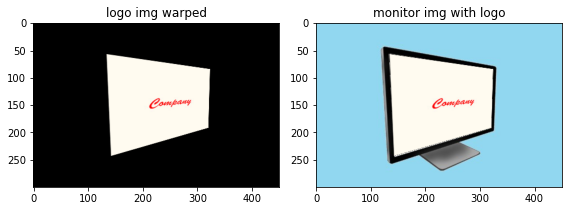

In [28]:
img_file = os.getcwd() + '\images\perspective_monitor.jpg'
img_monitor = cv2.imread(img_file)
img_monitor = img_monitor[:,:,::-1] # original monitor image
#plt.imshow(img_monitor); 

src_img_logo = img_logo.copy() # original logo 200x200
w,h = (src_img_logo.shape[1],src_img_logo.shape[0])
#plt.imshow(src_img_logo);

dst_img_monitor = img_monitor.copy() # copy of monitor image
dsize = (dst_img_monitor.shape[1],dst_img_monitor.shape[0])
dw,dh = (dsize)
#plt.imshow(dst_img_monitor);

# point match for warp perspective - replacing monitor screen with warped logo
src_pts = np.float32([[0,0],[h-1,0],[h-1,w-1],[0,w-1]]) # corners of logo - UL,LL,LR,UR
dst_pts = np.float32([[135,57],[323,84],[320,191],[143,242]]) 
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# generates a screen the size of monitor image (450x300)
# containing with logo in perspective with black background
# this overwrites dst_img_monitor 
dst_img_pers_logo_blk = cv2.warpPerspective(src_img_logo, M, dsize)
#plt.imshow(dst_img_pers_logo_blk);

# next step basically reads the perspective image separating black points
# from those with other colors (essentially warped logo)
# if it's something other than black it changes the corresponding pixel
# in the copy of the original monitor image

for i in range(dh):
    for j in range(dw):
        r, g, b = dst_img_pers_logo_blk[i,j]
        if r == 0 and g == 0 and b == 0:
            continue
        else:
            dst_img_monitor[i,j] = dst_img_pers_logo_blk[i,j]
            
          
# Display each of the transformed images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.imshow(dst_img_pers_logo_blk)
ax0.set_title("logo img warped")
ax1.imshow(dst_img_monitor)
ax1.set_title("monitor img with logo")
fig.tight_layout();

Figure 23. Projecting Company Logo on Monitor Screen using cv2

<a class="anchor" id="Perspective_Trans_PIL"></a>
<h4>4.2 Working with PIL Perspective Transformations</h4>
<a href='#toc'>Return to TOC</a>

The steps used in performing  a 'perspective transformation' with PIL are basically the same. However, the names of the methods and their specific parameters vary.

As before, we start by creating the source and destination images. With the images in hand we then specify the corresponding arrays or vectors of image coordinates (src_pts and dst_pts). These vectors are used to specify the perspective transformation matrix. Unlike cv2, PIL has no specific method for this purpose. Hince the function 'find_coeffs' which produces a transformation vector that is used by the PIL 'transform' method (in conjunction with the transformation type of 'PIL.Image.PERSPECTIVE') to generate the destination image containing the projected drone image surrounded by a black border (the image on the left side of Figure 24). Unlike a numpy array, replacing this black border with the rest of the monitor image is not as straightfoward as it is with cv2 and skimage. 

The reason for this difference between PIL and the other two libraries is that a PIL image does not allow 'immediate' access to the pixels in the image. In cv2 and skimage, it's simple to access the pixels because there images are numpy arrays. So, for instance, if you want to know the value of a particular pixel in a particular location, you simply specify the array and location of interest (e.g. img\[0,0\] yields the value or color at the origin). Similarly, if you want to change the value, then you simply specify the array and location and directly calculate the new value (e.g. img\[0,0\] = (0,0,255) which would change the value to blue). If you do either of these things with a PIL image, you get an error. The way to get around this is to first 'load' the image into an array and then use PIL's 'getpixel' or 'putpixel' methods to accomplish the same tasks. The code below illustrates how the 'load' and 'putpixel' methods are used to produce the final image of the drone projected on the monitor screen. The final result is shown on the right side of Figure 24.

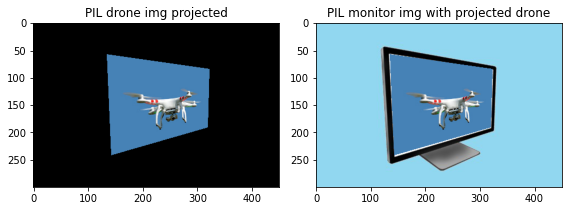

In [29]:
def find_coeffs(pb, pa): # generally it's pa,pb but with perspective it's pb,pa
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=float)
    B = np.array(pb).reshape(8)
    
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

# load the images
img_file = os.getcwd() + '\images\drone_bbg.jpg'
img_drone_PIL = PIL.Image.open(img_file)

img_file = os.getcwd() + '\images\perspective_monitor.jpg'
img_monitor_PIL = PIL.Image.open(img_file)

# create copies of drone (source) and monitor(destination) images
src_img_drone = img_drone_PIL.copy() # copy of drone image 300x300
dst_img_monitor = img_monitor_PIL.copy()

# determine the sizes of each image
src_w,src_h = src_img_drone.size
dst_w,dst_h = dst_img_monitor.size

# establish arrays of corresponding coordinates
src_pts = np.array([(0, 0), (src_w, 0), (src_w, src_h), (0, src_h)])
dst_pts = np.array([[135,57],[323,84],[320,191],[143,242]])

# create the transformation matrix
coeffs = find_coeffs(src_pts,dst_pts)

# compute the perspective image with black border
dst_img_drone_blk = src_img_drone.transform((dst_w, dst_h), PIL.Image.PERSPECTIVE, coeffs, PIL.Image.BICUBIC)

src_pixels = src_img_drone.load()
dst_pixels = dst_img_monitor.load()
dst_img_drone_blk_pixels = dst_img_drone_blk.load()

for i in range(dst_w):
    for j in range(dst_h):
        r, g, b = dst_img_drone_blk_pixels[i,j]
        if r == 0.0 and g == 0.0 and b == 0.0:
            continue
        else:
            dst_img_monitor.putpixel( (i, j), dst_img_drone_blk_pixels[i,j])

# Display each of the transformed images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.imshow(dst_img_drone_blk)
ax0.set_title("PIL drone img projected")
ax1.imshow(dst_img_monitor)
ax1.set_title("PIL monitor img with projected drone")
fig.tight_layout();



Figure 24. Projecting Drone on Monitor Screen using PIL

<a class="anchor" id="Perspective_Trans_sk"></a>
<h4>4.3 Working with skimage Perspective/Projection Transformations</h4>
<a href='#toc'>Return to TOC</a>

To illustrate the steps used to perform a perspective transformation with the skimage library, we'll rely on the same images as we used with the PIL library, i.e. projecting an image of a drone on to the monitor screen contained in a rectangular image containing the entire monitor. In this instance, skimage has a method or function that generates a transformation matrix whose structure is defined by the skimage 'transform.ProjectiveTransform' and estimated by a 'transform.Estimate' method using data from a vector of source image coordinates (src_pts) paired with a vector of destination image coordinates (dst_pts). These two vectors are essentially the same as they were with the cv2 and PIL libraries. Once the transformation matrix has been 'estimated', the actual projection is performed using transformation 'warp' method whose parameters include the original source image, the transformation matrix (tform) and and the shape of the output image. Again, the result is a projected image surrounded by a black border background (see the left-side of Figure 25). The final destination image with the drone on the computer screen is derived by replacing the original destination image with the non-black pixels (i.e. the drone) in the projected image. The end result is shown on the right-side of Figure 25.  

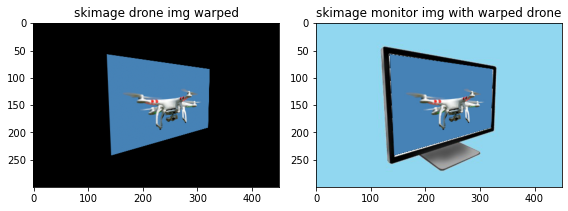

In [30]:
# load the images
img_file = os.getcwd() + '\images\drone_bbg.jpg'
img_drone_sk = skio.imread(img_file)

img_file = os.getcwd() + '\images\perspective_monitor.jpg'
img_monitor_sk = skio.imread(img_file)

src_img_drone = img_drone_sk.copy()
dst_img_monitor = img_monitor_sk.copy()

# height and width of the original drone and monitor images
src_h = src_img_drone.shape[0]
src_w = src_img_drone.shape[1]
dst_h = dst_img_monitor.shape[0]
dst_w = dst_img_monitor.shape[1]

src_pts = np.float32([[0,0],[src_h,0],[src_h,src_w],[0,src_w]]) # corners of logo - UL,LL,LR,UR
dst_pts = np.float32([[135,57],[323,84],[320,191],[143,242]]) 

# compute Projective Transformation matrix using src_pts and dst_pts
tform = tf.ProjectiveTransform()
tform.estimate(dst_pts, src_pts,)


dst_img_proj_drone_blk = tf.warp(src_img_drone, tform, output_shape=(dst_h,dst_w))

# replacing the pixels in the original destination image (dst_img_monitor)
# with non-black pixels from the projected image (dst_img_proj_logo_blk)
# The value of the pixels in the project image are given by (r,g,b) where
# r, g, and b are floats between 0.0-1.0. These need to be mapped to
# the integers between 0-255.

for i in range(dst_h):
    for j in range(dst_w):
        r, g, b = dst_img_proj_drone_blk[i,j]
        if r == 0 and g == 0 and b == 0:
            continue
        else:
            R = round(r * 255)
            G = round(g * 255)
            B = round(b * 255)
            dst_img_monitor[i,j] = (R,G,B)
            
# Display each of the transformed images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.imshow(dst_img_proj_drone_blk)
ax0.set_title("skimage drone img warped")
ax1.imshow(dst_img_monitor)
ax1.set_title("skimage monitor img with warped drone")
fig.tight_layout();


<a class="anchor" id="Closing_Comment"></a>
<h3>5. Closing Comment</h3>
<a href='#toc'>Return to TOC</a>

This above discussions about affine and perspective transformation only briefly touch on the transformation capabilities of the three image libraries. Interested readers are referred to the following documentation for much more detail:

<ul>
    <li><a href = 'https://docs.opencv.org/4.5.3/da/d54/group__imgproc__transform.html'>Reference for cv2 transformations</a></li>
    <li><a href = 'https://pillow.readthedocs.io/en/stable/reference/Image.html'>Reference for PIL transformations</a></li>
    <li><a href = 'https://scikit-image.org/docs/dev/api/skimage.transform.html'>Reference for skimage transformations</a></li>
</ul>